In [37]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import sqlite3
from scipy.signal import hilbert
import matplotlib.pyplot as plt

from scipy.signal import medfilt

In [21]:
def GetSpectrogramFeature(data_capture_id, sample_rate = 44100, hop_length = 44100):
    directory_name = "data/data_frames/data_capture_" + str(data_capture_id)
    if data_capture_id < 1700:
        wav_fn = directory_name + "/back_audio_data.wav"
        x, _ = librosa.load(wav_fn, sr = sample_rate)
    else:
        wav_fn = directory_name + "/audio_data.wav"
        x, _ = librosa.load(wav_fn, sr = sample_rate, mono = False)
        x = np.asfortranarray(x[0])
    
    S = librosa.feature.melspectrogram(y = x, sr = sample_rate, n_fft = 2048, n_mels = 128,
                                   fmax = 8000, hop_length=hop_length)
    X = librosa.power_to_db(S, ref=np.max)[::-1, :]
    
    return X

def PlotHighestFreqWithFiltered(data_capture_id, urine_regions, index = 0):
    X = GetSpectrogramFeature(data_capture_id)
    fig, axes = plt.subplots(2, 1, figsize = (10, 4), sharex = True)
    
    axes[0].plot(X[index])
    axes[1].plot(medfilt(X[index], 5))
    
    for region in urine_regions:
        axes[0].axvspan(region[0], region[1]+1, alpha=0.5, color='orange')
        axes[1].axvspan(region[0], region[1]+1, alpha=0.5, color='orange')
    plt.suptitle(data_capture_id)
    plt.show()

def ApplyEnvelope(sz):
    analytic_signal = hilbert(sz)
    env_sz = pd.Series(np.abs(analytic_signal))
    #env_sz.index = sz.index
    return env_sz

## Loud peer examples

use_i : 978, 1817, 1828, 1823, 1824

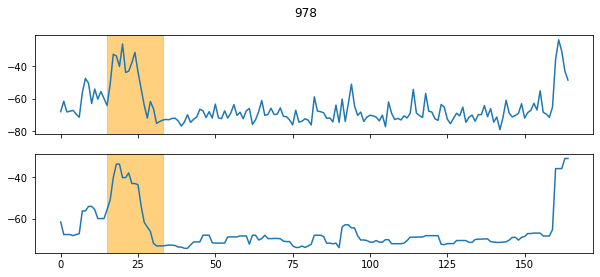

In [22]:
PlotHighestFreqWithFiltered(978, urine_regions = []) # loud

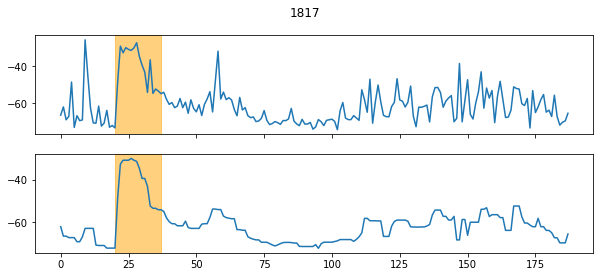

In [27]:
PlotHighestFreqWithFiltered(1817, urine_regions = [[20, 36]]) # loud

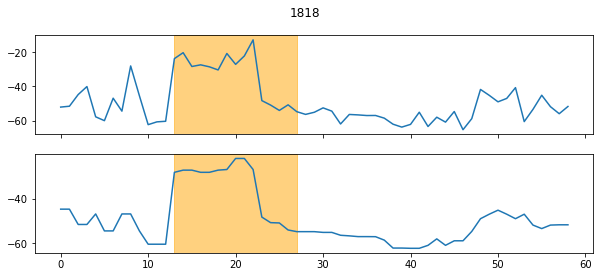

In [28]:
PlotHighestFreqWithFiltered(1818, urine_regions = [[13, 26]]) # loud

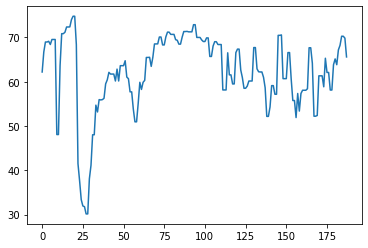

In [55]:
x = GetSpectrogramFeature(1817)
y = ApplyEnvelope(x[0])
plt.plot(medfilt(y))

In [ ]:
data_capture_id = 1767
sample_rate = 44100

directory_name = "data/data_frames/data_capture_" + str(data_capture_id)
wav_fn = directory_name + "/audio_data.wav"
x, fs = librosa.load(wav_fn, sr = sample_rate)
S = librosa.feature.melspectrogram(y = x, sr = sample_rate, n_fft = 2048, n_mels = 128,
                                   hop_length=sample_rate, fmax = 8000)

In [ ]:
X.shape

In [ ]:
fig, ax = plt.subplots(1)
X = librosa.power_to_db(S, ref=np.max)[:, :100]
librosa.display.specshow(X, fmax = 8000, sr = sample_rate, hop_length=sample_rate,
                         y_axis='mel', x_axis='time')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
pass

In [ ]:
data_capture_id = 1762
sample_rate = 44100

directory_name = "data/data_frames/data_capture_" + str(data_capture_id)
wav_fn = directory_name + "/audio_data.wav"
x, fs = librosa.load(wav_fn, sr = sample_rate)
S = librosa.feature.melspectrogram(y = x, sr = sample_rate, n_fft = 2048, n_mels = 128,
                                   fmax = 8000)
fig, ax = plt.subplots(1)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), fmax = 8000, sr = sample_rate,
                         y_axis='mel', x_axis='time')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
pass

In [ ]:
from sklearn.decomposition import PCA

S = librosa.feature.melspectrogram(y = x, sr = sample_rate, n_fft = 2048, n_mels = 128,
                                   hop_length= sample_rate, fmax = 8000)
X = librosa.power_to_db(S, ref=np.max)
pca = PCA(n_components=4)
X_ = pca.fit(X).transform(X)
X_.shape, S.shape

In [ ]:
cl = np.zeros(S.shape[0])
cl[10:15] = 1

plt.plot(X_[cl == 1, 0], X_[cl == 1, 1], 'r.', label = "urination")
plt.plot(X_[cl == 0, 0], X_[cl == 0, 1], 'b.', label = "none")
plt.legend()
plt.show()

In [ ]:
data_capture_id = 955
sample_rate = 44100

directory_name = "data/data_frames/data_capture_" + str(data_capture_id)
wav_fn = directory_name + "/back_audio_data.wav"
x, fs = librosa.load(wav_fn, sr = sample_rate)
S = librosa.feature.melspectrogram(y = x, sr = sample_rate, n_fft = 2048, n_mels = 128,
                                   fmax = 8000)
fig, ax = plt.subplots(1)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), fmax = 8000, sr = sample_rate,
                         y_axis='mel', x_axis='time')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
pass

In [ ]:
def GetSensor(use_i,sensor_i):
    sql_s = "SELECT timestamp_ms, value FROM data WHERE data_capture_id={} AND sensor_id={}".format(use_i,sensor_i)
    conn = sqlite3.connect('data/toilet.db')
    cursor = conn.execute(sql_s)
    time_measurements = []
    distance_measurements = []
    for row in cursor:
        time_measurements.append(row[0])
        distance_measurements.append(row[1])
    #endfor
    data_t = (time_measurements,distance_measurements)
    return data_t
#enddef

def cleanSensors(sensor1_t_l,sensor1_y_l,sensor2_t_l,sensor2_y_l):

    # get min / max of time-series
    #sensor1_t_l = data_d[1][0]
    #sensor2_t_l = data_d[2][0]
    #sensor1_y_l = data_d[1][1]
    #sensor2_y_l = data_d[2][1]
    min_t = min(min(sensor1_t_l),min(sensor2_t_l))
    max_t = max(max(sensor1_t_l),max(sensor2_t_l))

    # setup partitions
    step_t = 500
    min_floor_t = int(np.floor(min_t/step_t)*step_t)
    max_ceil_t = int(np.ceil(max_t/step_t)*step_t)
    
    step1_d = {}
    step2_d = {}
    for i in range(min_floor_t,max_ceil_t+step_t,step_t):
        step1_d[i] = []
        step2_d[i] = []
    #endfor

    # step through both and assign values to each partition
    for i in range(len(sensor1_t_l)):
        interval_t = int(np.floor(sensor1_t_l[i]/step_t)*step_t)
        step1_d[interval_t].append(sensor1_y_l[i])
    #endfor
    for i in range(len(sensor2_t_l)):
        interval_t = int(np.floor(sensor2_t_l[i]/step_t)*step_t)
        step2_d[interval_t].append(sensor2_y_l[i])
    #endfor

    # step through each partition and either take averages or set to nan
    clean1_d = {}
    for i in step1_d.keys():
        if(len(step1_d[i]) > 0):
            clean1_d[i] = np.mean(step1_d[i])
    #endfor
    clean1_sz = pd.Series(clean1_d)

    clean2_d = {}
    for i in step2_d.keys():
        if(len(step2_d[i]) > 0):
            clean2_d[i] = np.mean(step2_d[i])
    #endfor
    clean2_sz = pd.Series(clean2_d)
    
    return clean1_sz, clean2_sz

def GetTotalWeight(data_capture_id):
    data_d = {}
    data_d[2] = GetSensor(data_capture_id, 2) # seat scale
    data_d[3] = GetSensor(data_capture_id, 3) # foot scale
    
    #t0 = data_d[2][0][0]
    
    clean1_sz, clean2_sz = cleanSensors(data_d[2][0],data_d[2][1],data_d[3][0],data_d[3][1])
    seatScale_sz = clean1_sz/1000
    footScale_sz = clean2_sz/1000
    sumScale_sz = seatScale_sz  + footScale_sz
    #sumScaleFiltered_sz = pd.Series(signal.medfilt(sumScale_sz, 11))
        
    sumScale_sz.index = (sumScale_sz.index - sumScale_sz.index[0])/1000
    #x_ix = sumScale_sz.index
    return sumScale_sz